<h1>Fast Fourier Transform</h1>

The discrete Fourier transformation interpolates a set of values in the frequency basis given by trigonometric functions. 

<h2>DFT Matrix</h2>

Definte the $n$th root of unity as $\omega_{(n)} = e^{-2\pi i/n}$ so that ${\omega_{(n)}}^n=1$. 

In [25]:
import numpy as np

def omega(n):
    return np.exp(-2.*np.pi*1.j/n)

print(omega(2),omega(3),omega(4))
print(omega(2)**2,omega(3)**3,omega(4)**4)

(-1-1.22464679915e-16j) (-0.5-0.866025403784j) (6.12323399574e-17-1j)
(1+2.44929359829e-16j) (1+6.10622663544e-16j) (1+2.44929359829e-16j)


Lets plot $\omega_{(2)},\omega_{(3)},\ldots,\omega_{(n)}$ on the complex plane, highlighting in red $\omega_{(2)},\omega_{(4)},\omega_{(8)},\ldots,\omega_{(n)}$.

[ -1.00000000e+00 -1.22464680e-16j  -5.00000000e-01 -8.66025404e-01j
   6.12323400e-17 -1.00000000e+00j   3.09016994e-01 -9.51056516e-01j
   5.00000000e-01 -8.66025404e-01j   6.23489802e-01 -7.81831482e-01j
   7.07106781e-01 -7.07106781e-01j   7.66044443e-01 -6.42787610e-01j
   8.09016994e-01 -5.87785252e-01j   8.41253533e-01 -5.40640817e-01j
   8.66025404e-01 -5.00000000e-01j   8.85456026e-01 -4.64723172e-01j
   9.00968868e-01 -4.33883739e-01j   9.13545458e-01 -4.06736643e-01j
   9.23879533e-01 -3.82683432e-01j]


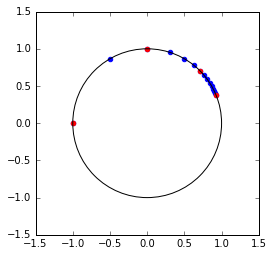

In [2]:
from matplotlib import pyplot as pt
n=16
omegas = np.zeros(n-1,dtype=complex)
expomegas = np.zeros(4,dtype=complex)

for i in np.arange(0,n-1):
    omegas[i] = omega(i+2)
    if 2**i <= n/2:
        expomegas[i] = omega(2**(i+1))

print(omegas)
pt.scatter(np.real(omegas),-np.imag(omegas),color='b')
pt.scatter(np.real(expomegas),-np.imag(expomegas),color='r')

circle= pt.Circle((0,0), radius= 1,fill=False)

ax=pt.gca()
ax.add_patch(circle)
pt.axis('scaled')
pt.show()

The **discrete Fourier transform** is defined by a matrix-vector product with a **DFT matrix** $\boldsymbol D \in \mathbb{R}^{n\times n}$ with $d_{jk}={\omega_{(n)}}^{jk}$.

In [27]:
def DFT(n):
    v = np.linspace(0,n-1,n) # v=[0,1,...,n-1]
    return omega(n)**np.outer(v,v)

np.asarray(np.real(DFT(4)),dtype=int)+1j*np.asarray(np.imag(DFT(4)),dtype=int)

array([[ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  0.-1.j, -1.+0.j,  0.+1.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j,  0.+1.j, -1.+0.j,  0.-1.j]])

The DFT matrix is symmetric (but not Hermitian) and with appropriate scaling, unitary i.e.  $n\boldsymbol D^{-1} = \boldsymbol D^{H}$.

In [28]:
import numpy.linalg as la
n=27
la.norm(n*np.eye(n) - DFT(n) @ DFT(n).conj())

2.2721682842512306e-12

<h2>FFT Algorithm</h2>

The **fast Fourier transform** exploits the special structure of the DFT matrix, computing the disrete Fourier transform of $\boldsymbol v$, given by $\boldsymbol u = \boldsymbol D \boldsymbol v$, in $O(n\log n)$ operations.

In [5]:
def fft(v):
    n = v.size
    if n is 1:
        return v
    u = fft(v[::2]) # compute FFT of [v_0,v_2,...v_{n-1}]
    w = fft(v[1::2]) # compute FFT of [v_1,v_3,...v_n]

    # scale w by twiddle factors [omega_(n)^0,...omega_(n)^(n/2-1)]
    t = np.asarray([omega(n)**i for i in range(n//2)]) 
    z = w*t

    return np.concatenate([u+z,u-z])

n = 16
v = np.random.random(n)+1.j*np.random.random(n)
la.norm(fft(v)-DFT(n)@v)

3.8305731252303524e-14

Two recursive calls on vectors of half the size are made, and $O(n)$ additions/products are done to apply the twiddle factors and add $z$ to $u$, for a cost of
$$T(n)=2T(n/2)+O(n)=O(n \log n).$$

<h2>Application to the 1D Poisson Equation</h2>

The solutions to the 1D Poisson equation are waves that correspond to Fourier modes, and the Fourier transform provides solutions to it directly when applied to the continuous equation or in the discretized form. From the linear algebra perspective, the DFT matrix is related to the eigenvectors of the tridiagonal differencing matrix (also linear stiffness matrix) $\boldsymbol T$.

In [6]:
n=7
T = 2*np.eye(n)-np.diag(np.ones(n-1),1)-np.diag(np.ones(n-1),-1)
T

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2.]])

The eigenvectors of $\boldsymbol T$ are $\boldsymbol X$ with eigenvalues $\boldsymbol d$ where
$$x_{jk} = \sqrt{\frac{2}{n+1}}\sin(jk\pi/(n+1)), \quad d_{k} = 2(1-\cos(\pi k/(n+1)).$$
The eigenvector matrix $\boldsymbol X$ is the imaginary part of a submatrix of the $2(n+1)$-dimensional DFT matrix. 

In [7]:
X = - np.sqrt(2/(n+1.)) * np.imag(DFT(2*(n+1))[1:n+1,1:n+1])
d = 2.*(1.-np.cos(np.pi*np.arange(1,n+1)/(n+1)))

#check that we indeed have the eigenvalue decomposition of T
la.norm(T@X-X@np.diag(d))

2.4218421576539674e-15

Thus we can apply $\boldsymbol X$, which is called the **discrete sine transform** via FFT.

In [8]:
def fast_DST(v):
    # setup a padded vector [0,v,0,...,0] of dimensions 2(n+1)
    w = np.concatenate([np.asarray([0.j]),v,0.j*np.zeros(v.size+1)])

    u = fft(w) # compute FFT of padded vector
    z = u-u.conj() # extract only imaginary part

    # return rescaled subvector
    return (-1.j*np.sqrt(1./(2.*(v.size+1.))))*z[1:1+v.size]

n = 7 # so that DFT dimension is 2(n+1)=16
X = - np.sqrt(2./(n+1.))*np.sin(np.pi*np.outer(np.arange(1,n+1),np.arange(1,n+1))/(n+1.))

v = np.random.random(n)

la.norm( X @ v - fast_DST(v))

1.0024720669331688e-15

Now, to solve the linear system $$\boldsymbol T \boldsymbol x = \boldsymbol b$$ it suffices to compute $$\boldsymbol x = \boldsymbol X \text{diag}(\boldsymbol d)^{-1} \boldsymbol X^{-1} \boldsymbol b,$$
and since the sine transform is orthogonal, we simply have $$\boldsymbol x = \boldsymbol X \text{diag}(\boldsymbol d)^{-1} \boldsymbol X^{T} \boldsymbol b.$$

In [9]:
n = 7
b = np.random.random(n)
T = 2*np.eye(n)-np.diag(np.ones(n-1),1)-np.diag(np.ones(n-1),-1)
x = la.solve(T,b)

d = 2.*(1.-np.cos(np.pi*np.arange(1,n+1)/(n+1)))
X = - np.sqrt(2./(n+1.))*np.sin(np.pi*np.outer(np.arange(1,n+1),np.arange(1,n+1))/(n+1.))

la.norm(x - fast_DST(np.diag(1./d) @ X.T @ b))

3.820199830714189e-15

<h2>Application to the 2D Poisson Equation</h2>

Lets now consider the discretized 2D Poisson PDE, where the linear system takes on a Kronecker-product form.

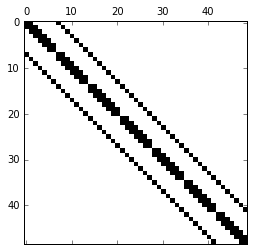

In [11]:
n=7
T = 2*np.eye(n)-np.diag(np.ones(n-1),1)-np.diag(np.ones(n-1),-1)
A = np.kron(np.eye(n),T)+np.kron(T,np.eye(n))
pt.spy(A)

The 1D finite differencing matrix $\boldsymbol T$, gives us the following equations for the unknowns $\boldsymbol U\in\mathbb{R}^{m\times m}$ for an $m\times m$ spatial mesh,
$$\boldsymbol T \boldsymbol U + \boldsymbol U \boldsymbol T= \boldsymbol F,$$
where we've absorbed the discretization width $h$ into $\boldsymbol F$.

In [20]:
F = np.random.random((n,n))
U = la.solve(A,F.reshape(n*n)).reshape((n,n))
la.norm(T@U+U@T-F)

5.9061360594505111e-15

Using the eigenvalue decomposition of $\boldsymbol T=\boldsymbol X \text{diag}(\boldsymbol d) \boldsymbol X^{-1}$, which we know analytically, we can write the frequency space form of the linear system as
$$\text{diag}(\boldsymbol d) \boldsymbol X^{-1} \boldsymbol U \boldsymbol X + \boldsymbol X^{-1} \boldsymbol U \boldsymbol X\text{diag}(\boldsymbol d)  =  \boldsymbol X^{-1} \boldsymbol F \boldsymbol X,$$
so we compute the 2D sine transform of $\boldsymbol F$ and solve a diagonal linear system for $\boldsymbol V=\boldsymbol X^{-1} \boldsymbol U \boldsymbol X$, which is the 2D sine transform of the solution.

In [24]:
X = - np.sqrt(2/(n+1.)) * np.imag(DFT(2*(n+1))[1:n+1,1:n+1])
d = 2.*(1.-np.cos(np.pi*np.arange(1,n+1)/(n+1)))

# transform F
sF = X.T @ F @ X

# perform pointwise product to solve for U
sU = sF / np.add.outer(d,d)

# backtransform U and compare to naive method
la.norm(U - X @ sU @ X.T)

7.115828086306871e-15